In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Data Preparation

In [2]:
file_path = Path("crypto_data.csv")
crypto_df = pd.read_csv(file_path)
#Only coins that are trading
crypto_df = crypto_df[crypto_df['IsTrading']==True]
#Drop IsTrading Column
crypto_df = crypto_df.drop(columns=['IsTrading'])
#Remove rows that have at least one null value
crypto_df = crypto_df.dropna(how='any',axis=0)
#TotalCoinsMined > 0
crypto_df = crypto_df[crypto_df['TotalCoinsMined']>0]
#Remove Coin Name
crypto_df = crypto_df.drop(columns=['CoinName'])
crypto_df = crypto_df.drop(columns=['Unnamed: 0'])
crypto_df

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0
...,...,...,...,...
1238,SHA-256,DPoS,2.000000e+09,2000000000
1242,Scrypt,PoW/PoS,1.493105e+07,250000000
1245,CryptoNight,PoW,9.802226e+08,1400222610
1246,Equihash,PoW,7.296538e+06,21000000


In [3]:
algorithms = {}
algorithmsList = crypto_df['Algorithm'].unique().tolist()
for i in range(len(algorithmsList)):
    algorithms[algorithmsList[i]] = i

proofType = {}
proofTypeList = crypto_df['ProofType'].unique().tolist()
for i in range(len(proofTypeList)):
    proofType[proofTypeList[i]] = i

crypto_df = crypto_df.replace(({'Algorithm':algorithms}))
crypto_df = crypto_df.replace(({'ProofType':proofType}))
crypto_df.dtypes

Algorithm            int64
ProofType            int64
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [4]:
# Standarize data with StandarScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(crypto_df[['TotalCoinsMined', 'TotalCoinSupply']])
new_df_crypto = pd.DataFrame(scaled_data, columns=crypto_df.columns[2:])
new_df_crypto['Algorithm']=crypto_df['Algorithm'].values
new_df_crypto['ProofType']=crypto_df['ProofType'].values
new_df_crypto

,TotalCoinsMined,TotalCoinSupply,Algorithm,ProofType
0,-0.117108,-0.152870,0,0
1,-0.093970,-0.145009,0,0
2,0.524946,4.489424,1,0
3,-0.116715,-0.152560,2,1
4,-0.114747,-0.152870,3,1
...,...,...,...,...
527,-0.073251,-0.123317,2,10
528,-0.116781,-0.149176,0,0
529,-0.095613,-0.132179,18,1
530,-0.116948,-0.152560,6,1


## Dimensionality Reduction

In [11]:
#PCA
pca = PCA(n_components=3)

In [12]:
crypto_pca = pca.fit_transform(new_df_crypto)

In [13]:
pca.explained_variance_ratio_.sum()

0.9989521160793909

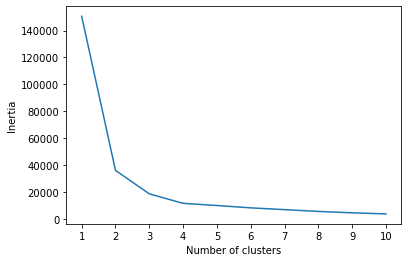

In [10]:
inertia = []
# Same as k = list(range(1, 11))
k = [1,2,3,4,5,6,7,8,9,10]


# Looking for the best k
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(new_df_crypto)
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [15]:
df_crypto_pca = pd.DataFrame(
    data=crypto_pca,
    columns=["principal component 1", "principal component 2", "principal component 3"],
)
df_crypto_pca.head()

,principal component 1,principal component 2,principal component 3
0,-10.802869,-0.909429,-0.028480
1,-10.802599,-0.908453,-0.006637
2,-9.765501,-0.829928,3.710423
3,-8.750917,-0.022963,-0.088324
4,-7.752489,-0.078472,-0.096443


In [19]:
# Initialize the K-Means model
model = KMeans(n_clusters=3, random_state=0)

# Fit the model
model.fit(df_crypto_pca)

# Predict clusters
predictions = model.predict(df_crypto_pca)

# Add the predicted class columns
df_crypto_pca["class"] = model.labels_
df_crypto_pca.head()

,principal component 1,principal component 2,principal component 3,class
0,-10.802869,-0.909429,-0.028480,0
1,-10.802599,-0.908453,-0.006637,0
2,-9.765501,-0.829928,3.710423,0
3,-8.750917,-0.022963,-0.088324,0
4,-7.752489,-0.078472,-0.096443,0


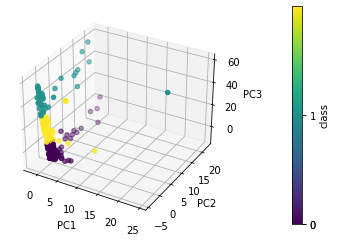

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

z = df_crypto_pca['principal component 1']
y = df_crypto_pca['principal component 2']
x = df_crypto_pca['principal component 3']

p = ax.scatter3D(x,y,z,c=df_crypto_pca['class'],cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
cbar = fig.colorbar(p,ticks=[0,1,0],pad=0.2)
cbar.set_label('class')

In [27]:
new_df_crypto
model.fit(new_df_crypto)

# Predict clusters
predictions = model.predict(new_df_crypto)
df = new_df_crypto
# Add the predicted class columns
df["class"] = model.labels_

df2 = df.drop(['class'], axis=1)
labels = df['class']
df2

,TotalCoinsMined,TotalCoinSupply,Algorithm,ProofType
0,-0.117108,-0.152870,0,0
1,-0.093970,-0.145009,0,0
2,0.524946,4.489424,1,0
3,-0.116715,-0.152560,2,1
4,-0.114747,-0.152870,3,1
...,...,...,...,...
527,-0.073251,-0.123317,2,10
528,-0.116781,-0.149176,0,0
529,-0.095613,-0.132179,18,1
530,-0.116948,-0.152560,6,1


In [28]:
# Initialize t-SNE model
tsne = TSNE(learning_rate=35)

In [29]:
# Reduce dimensions
tsne_features = tsne.fit_transform(df2)

In [30]:
# The dataset has 2 columns
tsne_features.shape

(532, 2)

In [32]:
# Prepare to plot the dataset

# The first column of transformed features
df2['x'] = tsne_features[:,0]

# The second column of transformed features
df2['y'] = tsne_features[:,1]

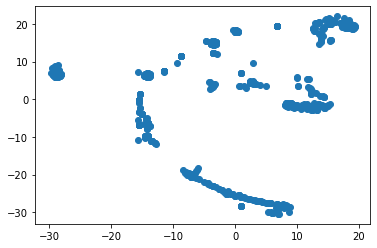

In [33]:
# Visualize the clusters
plt.scatter(df2['x'], df2['y'])
plt.show()

In [34]:
labels.value_counts()

0    408
2     81
1     43
Name: class, dtype: int64

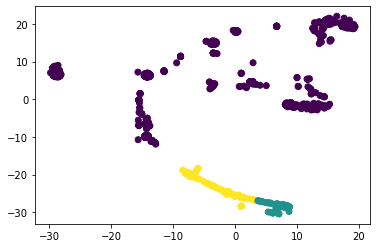

In [35]:
# Visualize the clusters with color
plt.scatter(df2['x'], df2['y'], c=labels)
plt.show()